In [1]:
train_dir = 'D:/Documentos/Estudio/Maestría/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Train' 
val_dir = 'D:/Documentos/Estudio/Maestría/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Val' 
test_dir = 'D:/Documentos/Estudio/Maestría/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Test'

In [2]:
#ELEGIMOS LOS PARAMETROS
from keras.preprocessing.image import ImageDataGenerator
ih, iw = 50, 50 #tamano de la imagen
input_shape = (ih, iw, 3) #forma de la imagen: alto ancho y numero de canales

num_class = 3 #cuantas clases 
#epochs = 15 #cuantas veces entrenar. En cada epoch hace una mejora en los parametros

batch_size = 32 #batch para hacer cada entrenamiento. Lee 50 'batch_size' imagenes antes de actualizar los parametros. Las carga a memoria
num_train = 21715 #numero de imagenes en train
num_test = 6788 #numero de imagenes en test
num_val=5417

epoch_steps = num_train // batch_size 
test_steps = num_test // batch_size
 

Using TensorFlow backend.


In [3]:
#LEEMOS LAS IMÁGENES 

img_height, img_width=ih, iw

train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as training data

validation_generator = train_datagen.flow_from_directory(
    val_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as validation data

test_generator = train_datagen.flow_from_directory(
    test_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as validation data

Found 21715 images belonging to 3 classes.
Found 5417 images belonging to 3 classes.
Found 6788 images belonging to 3 classes.


In [4]:
train=train_generator
val=validation_generator
test=test_generator

In [19]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, DenseNet121, ResNet152V2, NASNetLarge
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2

densenet121_model = DenseNet121(include_top=False, weights='imagenet',  
                                     input_shape=input_shape) 

densenet121_model.trainable=True

In [ ]:
#for layer in Xception_model.layers[:-40]:
#    layer.trainable = False

In [20]:
import pandas as pd 
pd.set_option('max_colwidth', -1)

layers = [(layer, layer.name, layer.trainable) for layer in densenet121_model.layers] 
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

C:\Users\elium\.conda\envs\tfGPU\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x0000025FFEB04AC8>,input_2,True
1,<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x0000025FFD33BAC8>,zero_padding2d,True
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000025FFD141F88>,conv1/conv,True
3,<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x0000025FEFB9C6C8>,conv1/bn,True
4,<tensorflow.python.keras.layers.core.Activation object at 0x0000025FF4C70A88>,conv1/relu,True
...,...,...,...
422,<tensorflow.python.keras.layers.core.Activation object at 0x0000026002788E08>,conv5_block16_1_relu,True
423,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002600278F648>,conv5_block16_2_conv,True
424,<tensorflow.python.keras.layers.merge.Concatenate object at 0x00000260027E6648>,conv5_block16_concat,True
425,<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x00000260019E7A48>,bn,True


In [21]:
densenet121_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 50, 50, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 56, 56, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 25, 25, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 25, 25, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [ ]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [27]:

from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import to_categorical 
from keras import optimizers 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, BatchNormalization
# build model architecture 
model = Sequential()
model.add(densenet121_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_class, activation='softmax'))
#compile model
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9), 
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True), 
      metrics=['accuracy',f1_m,precision_m, recall_m])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 1, 1, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               262400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                

In [28]:
history = model.fit_generator(train, steps_per_epoch=100, 
                              epochs=50,  
                              validation_data=val,   
                              validation_steps=50,  
                              verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/50
100/100 [==============================] - 16s 162ms/step - loss: 1.0730 - accuracy: 0.4031 - val_loss: 0.9931 - val_accuracy: 0.5750
Epoch 2/50
100/100 [==============================] - 6s 59ms/step - loss: 0.9518 - accuracy: 0.6269 - val_loss: 0.8791 - val_accuracy: 0.7513
Epoch 3/50
100/100 [==============================] - 6s 59ms/step - loss: 0.8548 - accuracy: 0.7516 - val_loss: 0.8142 - val_accuracy: 0.7894
Epoch 4/50
100/100 [==============================] - 6s 58ms/step - loss: 0.8121 - accuracy: 0.7835 - val_loss: 0.7802 - val_accuracy: 0.8075
Epoch 5/50
100/100 [==============================] - 6s 58ms/step - loss: 0.7675 - accuracy: 0.8250 - val_loss: 0.7611 - val_accuracy: 0.8206
Epoch 6/50
100/100 [==============================] - 6s 58ms/step - loss: 0.7561 - accuracy: 0.8231 - val_loss: 0.7510 - val_accuracy: 0.8219
Epoch 7/50
100/100 [===========================

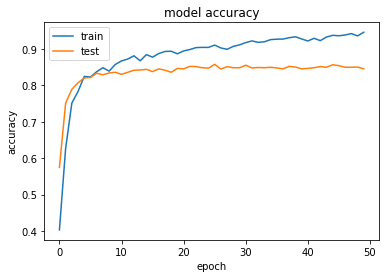

In [29]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

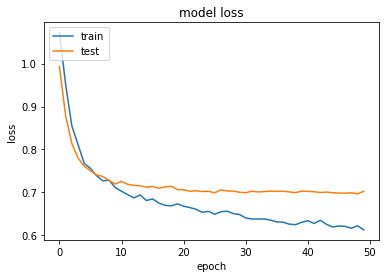

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [31]:
test_eval = model.evaluate(test, verbose=1)
print('El modelo predice el ', test_eval[1]*100,'% de los datos')

  ...
    to  
  ['...']
213/213 [==============================] - 14s 68ms/step - loss: 0.6839 - accuracy: 0.8631
El modelo predice el  86.31408214569092 % de los datos
